In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf

In [2]:
#查看tensorflow版本
tf.__version__

'1.9.0'

In [3]:
#tensorflow下载minist数据集
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [4]:
#分别查看训练集和测试集的特征、标签的大小
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [5]:
X_train[:2]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

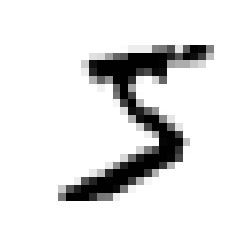

In [6]:
def display(img):
    plt.axis('off')
    plt.imshow(img, cmap=cm.binary)
# output image     
display(X_train[0])

In [7]:
#同时打印出图片对应的标签的数值
y_train[0]

5

In [8]:
#统计标签y的个数
labels_count = len(set(y_train))
print (labels_count)
print (y_train)

10
[5 0 4 ... 5 6 8]


In [9]:
X_train1 = X_train.reshape(60000,784)
X_test1 = X_test.reshape(10000,784)
X_train1[:2]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

In [11]:
train_labels = dense_to_one_hot(y_train, labels_count)
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [12]:
# split data into training & validation,将全部的训练集分为训练集和验证集
validation_images = X_train1[:10000]
validation_labels = train_labels[:10000]
train_images = X_train1[10000:]
train_labels = train_labels[10000:]
print('train_images({0[0]},{0[1]})'.format(train_images.shape))
print('validation_images({0[0]},{0[1]})'.format(validation_images.shape))

train_images(50000,784)
validation_images(10000,784)


In [32]:
# 设置学习率
LEARNING_RATE = 1e-3
#训练总次数，迭代100
TRAINING_ITERATIONS = 1000 

#随机不连接的神经元占比为50%    
DROPOUT = 0.5
BATCH_SIZE = 128


#设置读入的图片的大小
image_width =28
image_height = 28
image_size = image_width*image_height

In [14]:
# weight initialization，初始化权重矩阵，初始化为服从正态分布的随机变量
#shape是指某一层输入和输出的个数
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

#偏差bias初始化为常量0.1
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [20]:
#定义卷积，tf.nn.conv2d函数是tensoflow里面的二维的卷积函数，
#x是图片的所有参数，W是此卷积层的权重，然后定义步长strides=[1,1,1,1]值，
#strides[0]和strides[3]的两个1是默认值，中间两个1代表padding时在x方向运动一步，y方向运动一步，padding采用的方式是valid，但是此时效果与padding取same相同
#padding是边框填充的参数，取值为same和valid，padding取valid是在convolution层若filter后只剩下1列或不够filter列时，直接将数据丢弃，但是padding取same会自动在后面填充0，继续filter
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

In [21]:
#定义池化函数pooling，为了得到更多的图片信息，padding时我们选的是一次一步，
#也就是strides[1]=strides[2]=1，这样得到的图片尺寸没有变化，
#而我们希望压缩一下图片也就是参数能少一些从而减小系统的复杂度，
#因此我们采用pooling来稀疏化参数，也就是卷积神经网络中所谓的下采样层。
#pooling 有两种，一种是最大值池化，一种是平均值池化，本例采用的是最大值池化tf.max_pool()。
#池化的核函数大小为2x2，因此ksize=[1,2,2,1]，步长为2，因此strides=[1,2,2,1]:
def max_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

In [22]:
# images,输入是未知个数的图片特征，每个图片为784维，里面每个元素类型是浮点型
x = tf.placeholder('float', shape=[None, image_size])
# labels，标签是未知个数，但是每个标签的维度是10
y_ = tf.placeholder('float', shape=[None, labels_count])

In [25]:
#定义整个LeNet5的网络结构

# 定义第一层卷积,先定义本层的Weight,本层我们的卷积核的大小是5x5，因为黑白图片channel是1所以输入是1，输出是6个featuremap
W_conv1 = weight_variable([5, 5, 1, 6])
b_conv1 = bias_variable([6])

#把xs的形状变成[-1,28,28,1]，-1代表先不考虑输入的图片例子多少这个维度，
#后面的1是channel的数量，因为我们输入的图片是黑白的，因此channel是1，例如如果是RGB图像，那么channel就是3。
# (50000,784) => (50000,28,28,1)
image = tf.reshape(x, [-1,image_width , image_height,1])
#print (image.get_shape()) # =>(50000,24,24,1)

#定义卷积神经网络的第一个卷积层h_conv1=conv2d(x_image,W_conv1)+b_conv1,
#同时我们对h_conv1进行非线性处理，也就是激活函数来处理喽，
#这里我们用的是tf.nn.relu（修正线性单元）来处理，要注意的是，
#因为采用了SAME的padding方式，输出图片的大小没有变化依然是24x24，只是厚度变厚了，因此现在的输出大小就变成了24x24x6
h_conv1 = tf.nn.relu(conv2d(image, W_conv1) + b_conv1)
#print (h_conv1.get_shape()) # => (50000, 24, 24, 6)

#第一个pooling层，经过max_pooling输出变成14x14x6
h_pool1 = max_pool_2x2(h_conv1)
#print (h_pool1.get_shape()) # => (50000, 12, 12, 6)

#第二个卷积层,本层我们的卷积核的大小是5x5，因为channel是第一个pool层输出的6，输出是16个featuremap
W_conv2 = weight_variable([5, 5, 6, 16])
b_conv2 = bias_variable([16])
h_conv2 = tf.nn.relu(conv2d(h_pool1,W_conv2) + b_conv2)
#print (h_conv2.get_shape()) # => (50000, 8, 8, 16)

#第二个pooling层，经过max_pooling输出变成14x14x16
h_pool2 = max_pool_2x2(h_conv2)
#print (h_pool1.get_shape()) # => (50000, 4, 4, 16)

#第5层，第一个全连接层,上一个池化层的经过flatten是256个神经元
conv_layer_flatten = tf.layers.flatten(inputs = h_pool2)
fc1_variable = weight_variable([256, 120])
fc1_bias = bias_variable(shape = [1, 120])
fc1 = tf.nn.relu(tf.add(tf.matmul(conv_layer_flatten, fc1_variable), fc1_bias))   

#第六层，第二个全连接层，该层的神经元个数是120
fc2_variable = weight_variable([120,84]) 
fc2_bias = bias_variable(shape=[1, 84])
fc2 = tf.nn.relu(tf.add(tf.matmul(fc1, fc2_variable), fc2_bias))            
        
#第七层，第三个全连接层
output_variable = weight_variable([84, 10])
output_bias = bias_variable(shape = [1, 10])
y = tf.add(tf.matmul(fc2, output_variable), output_bias)

In [26]:
# cost function,分类问题的损失函数用cross_entropy
cross_entropy = -tf.reduce_sum(y_*tf.log(y))

# optimisation function,优化函数
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)

# evaluation，根据输出层的最大的Y值为输出的标签
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

In [27]:
predict = tf.argmax(y,1)

In [28]:
epochs_completed = 0
index_in_epoch = 0
#训练样本个数
num_examples = train_images.shape[0]

# serve data by batches
def next_batch(batch_size):
    
    global train_images
    global train_labels
    global index_in_epoch
    global epochs_completed
    #从哪一个样本开始训练，每次用batch_sice个样本
    start = index_in_epoch
    index_in_epoch += batch_size
    
    # when all trainig data have been already used, it is reorder randomly    
    if index_in_epoch > num_examples:
        # finished epoch
        epochs_completed += 1
        # shuffle the data
        perm = np.arange(num_examples)
        np.random.shuffle(perm) #随机打乱所有的样本集
        train_images = train_images[perm]
        train_labels = train_labels[perm]
        # start next epoch
        start = 0
        index_in_epoch = batch_size
        assert batch_size <= num_examples
    end = index_in_epoch
    return train_images[start:end], train_labels[start:end]

In [29]:
#神经网络的初始化，包括参数初始化和session初始化，以下的初始化语句必须有
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

In [33]:
train_accuracies = []
validation_accuracies = []
x_range = []
#每隔几次输出当前的训练误差和验证误差
display_step=1

for i in range(TRAINING_ITERATIONS):
    #get new batch
    batch_xs, batch_ys = next_batch(BATCH_SIZE)        

    # check progress on every 1st,2nd,...,10th,20th,...,100th... step
    if i%display_step == 0 or (i+1) == TRAINING_ITERATIONS:
        
        train_accuracy = accuracy.eval(feed_dict={x:batch_xs, 
                                                  y_: batch_ys})       
        if(VALIDATION_SIZE):
            validation_accuracy = accuracy.eval(feed_dict={ x: validation_images[0:BATCH_SIZE], 
                                                            y_: validation_labels[0:BATCH_SIZE]})                                  
            print('training_accuracy / validation_accuracy => %.2f / %.2f for step %d'%(train_accuracy, validation_accuracy, i))
            
            validation_accuracies.append(validation_accuracy)
            
        else:
             print('training_accuracy => %.4f for step %d'%(train_accuracy, i))
        train_accuracies.append(train_accuracy)
        x_range.append(i)
        
        # increase display_step
        if i%(display_step*10) == 0 and i:
            display_step *= 10
    # train on batch
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

training_accuracy / validation_accuracy => 0.11 / 0.10 for step 0
training_accuracy / validation_accuracy => 0.13 / 0.10 for step 1
training_accuracy / validation_accuracy => 0.06 / 0.10 for step 2
training_accuracy / validation_accuracy => 0.12 / 0.10 for step 3
training_accuracy / validation_accuracy => 0.09 / 0.10 for step 4
training_accuracy / validation_accuracy => 0.12 / 0.10 for step 5
training_accuracy / validation_accuracy => 0.09 / 0.10 for step 6
training_accuracy / validation_accuracy => 0.12 / 0.10 for step 7
training_accuracy / validation_accuracy => 0.10 / 0.10 for step 8
training_accuracy / validation_accuracy => 0.09 / 0.10 for step 9
training_accuracy / validation_accuracy => 0.06 / 0.10 for step 10
training_accuracy / validation_accuracy => 0.09 / 0.10 for step 20
training_accuracy / validation_accuracy => 0.10 / 0.10 for step 30
training_accuracy / validation_accuracy => 0.14 / 0.16 for step 40
training_accuracy / validation_accuracy => 0.12 / 0.16 for step 50
train